In [ ]:
#Print current hardware information (variable in Colab) 

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Feb  3 15:28:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%%capture
#@title
import os
import sys
import tensorflow.compat.v1 as tf

Read from my Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Move to "_modified-EfficientDet" folder and install requirements

In [ ]:
os.chdir('drive/MyDrive/_modified-EfficientDet')
sys.path.append('.')
!pip install -r requirements.txt
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-h8kljntp
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-h8kljntp
     |████████████████████████████████| 6.4 MB 5.0 MB/s 
     |████████████████████████████████| 596 kB 54.4 MB/s 
     |████████████████████████████████| 1.1 MB 60.8 MB/s 
     |████████████████████████████████| 120 kB 74.8 MB/s 
     |████████████████████████████████| 213 kB 76.7 MB/s 
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263931 sha256=1915b4734cd416b51427e5050d90bc086f668ede181e5bfe47b5bd2696a0285a
  Stored in directory: /tmp/pip-ephem-wheel-cache-r1lk48jf/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: pycocotools
    Found exi

In [ ]:
MODEL = 'efficientdet-d3_1-5'  #@param

Inference images with bounding boxes

In [ ]:
# first export a saved model. "image_size" = 512x512 for d0, 640x640 for d1, 768x768 for d2 and 896x896 for d3.
saved_model_dir = 'savedmodel'
!rm -rf {saved_model_dir}
!python model_inspect.py --runmode=saved_model --model_name={MODEL} \
  --ckpt_path='tmp_model_dir/efficientdet-d3_1-5-scratch-Trash'  --hparams="num_classes=3,moving_average_decay=0,image_size=896x896,mixed_precision=true" \
  --batch_size=1 --saved_model_dir={saved_model_dir}  

2022-02-03 18:13:20.750989: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.

W0203 18:13:21.098637 139686817056640 module_wrapper.py:155] From /content/drive/MyDrive/_modified-EfficientDet/utils.py:601: The name tf.keras.layers.enable_v2_dtype_behavior is deprecated. Please use tf.compat.v1.keras.layers.enable_v2_dtype_behavior instead.

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-16GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
W0203 18:13:21.099742 139686817056640 device_compatibility_check.py:107] Mixed preci

In [ ]:
import cv2

image_dimension = 896

im = cv2.imread('inference_images/obj0212_frame0000048.jpg')
print(im.shape)

im = cv2.resize(im,(image_dimension, image_dimension))
print(im.shape)

cv2.imwrite('inference_images/obj0212_frame0000048.jpg', im)


(768, 768, 3)
(896, 896, 3)


True

In [ ]:
# Then run saved_model_infer to do inference.
# Notably: batch_size, image_size must be the same as when it is exported.       
serve_image_out = 'serve_image_out'
!mkdir {serve_image_out}

min_score_thresh = 0  
max_boxes_to_draw = 200  
line_thickness =   2

!python model_inspect.py --runmode=saved_model_infer \
  --saved_model_dir={saved_model_dir} \
  --model_name={MODEL}  --input_image=inference_images/obj0212_frame0000048.jpg  \
  --output_image_dir={serve_image_out} --hparams="moving_average_decay=0,mixed_precision=true" \
  --min_score_thresh={min_score_thresh}  --max_boxes_to_draw={max_boxes_to_draw}

mkdir: cannot create directory ‘serve_image_out’: File exists
2022-02-03 18:19:24.696830: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
W0203 18:19:24.697935 140636514723712 deprecation.py:347] From /content/drive/MyDrive/_modified-EfficientDet/inference.py:570: load (from tensorflow.python.saved_model.loader_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Te

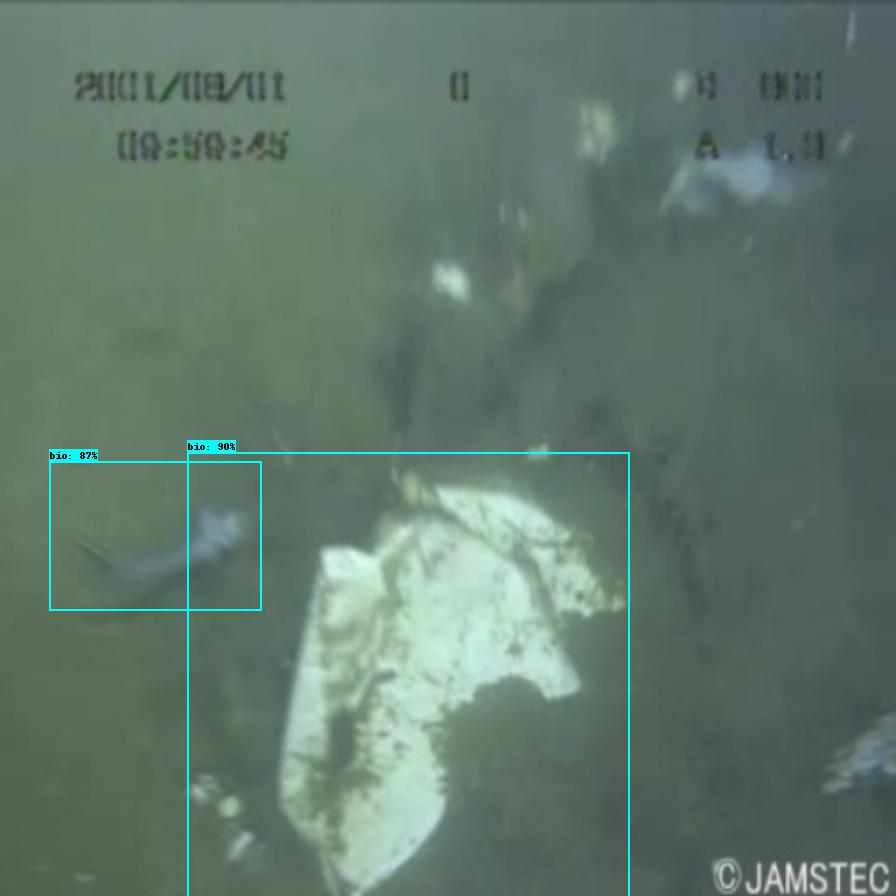

In [ ]:
from IPython import display
display.display(display.Image(os.path.join(serve_image_out, '0.jpg')))

REFERENCES

[1] F. Zocco et al., Towards More Efficient EfficientDets and Low-Light Real-Time Marine Debris Detection, https://arxiv.org/pdf/2203.07155.pdf

[2] https://github.com/google/automl/blob/master/efficientdet/tutorial.ipynb

[3] https://openaccess.thecvf.com/content_CVPR_2020/papers/Tan_EfficientDet_Scalable_and_Efficient_Object_Detection_CVPR_2020_paper.pdf

